# Neural Approach

Motivation : We are trying to use the encoding power of BERT associated with an auto-encoder in order to find a low-dimensional vector representation of the combination lemma+morphological_attributes and a low-dimensional representation of a form. 

## Importing Bert

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [2]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-multilingual-cased')

In [9]:
f = open("task0-data/DEVELOPMENT-LANGUAGES/uralic/fin.dev",encoding="utf-8")

lemmas = []
form = []
morph = []
all_input = []
for lines in f.readlines():
    a, b, c = lines.split("\t")
    lemmas.append(a)
    form.append(b)
    morph.append(c.split(";")[:-2])
    all_input.append(b+';'+''.join(c.split(";")[:-2]))

In [12]:
df2 = pd.DataFrame(all_input)
df2.head()

,0
0,otsonisuojineen;N
1,lujennee;VPOTSG3POS
2,rokotusarvissa;N
3,faileiksi;N
4,seeprakirjoahveneksi;N


In [11]:
df = pd.DataFrame(morph)
#df['lemmas'] = lemmas
#df['form'] = form
df.head()

,0,1,2,3,4,lemmas,form
0,N,None,None,None,None,otsonisuoja,otsonisuojineen
1,V,POT,SG,3,POS,lujeta,lujennee
2,N,None,None,None,None,rokotusarpi,rokotusarvissa
3,N,None,None,None,None,faili,faileiksi
4,N,None,None,None,None,seeprakirjoahven,seeprakirjoahveneksi


In [13]:
batch_1 = df2[:]

In [14]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [16]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [17]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(14201, 19)

In [19]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [20]:
features = last_hidden_states[0][:,0,:].numpy()
print(features.shape)

(14201, 768)


In [21]:
form_series = pd.Series(form[:]) 
tokenized_labels = form_series.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized_labels.values:
    if len(i) > max_len:
        max_len = len(i)

padded_labels = np.array([i + [0]*(max_len-len(i)) for i in tokenized_labels.values])
attention_mask_labels = np.where(padded_labels != 0, 1, 0)
input_ids_labels = torch.tensor(padded_labels)  
attention_mask_labels = torch.tensor(attention_mask_labels)

with torch.no_grad():
    labels_layer = model(input_ids_labels, attention_mask=attention_mask_labels)

In [22]:
labels = labels_layer[0][:,0,:].numpy()

In [64]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [177]:
np.savetxt('train_features.csv',train_features, delimiter=',')
np.savetxt('test_features.csv',test_features, delimiter=',')
np.savetxt('train_labels.csv',train_labels, delimiter=',')
np.savetxt('test_labels.csv',test_labels, delimiter=',')

In [65]:
np.array(train_labels).shape

(10650, 768)

# AutoEncoder

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np

In [2]:
train_features = np.loadtxt('train_features.csv',delimiter=',')
test_features = np.loadtxt('test_features.csv',delimiter=',')
train_labels = np.loadtxt('train_labels.csv',delimiter=',')
test_labels = np.loadtxt('test_labels.csv',delimiter=',')


In [14]:
torch.cuda.empty_cache()

In [15]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(np.array(train_labels), batch_size=64, shuffle=True)
test_dataloader = DataLoader(np.array(test_labels), batch_size=64, shuffle=True)


In [149]:
batch_size = 1024
epochs = 1000
learning_rate = 1e-4
lam = 0

In [150]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=300
        )
        self.encoder_output_layer = nn.Linear(
            in_features=300, out_features=10,bias = False
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=10, out_features=300,bias = False
        )
        self.decoder_output_layer = nn.Linear(
            in_features=300, out_features=kwargs["input_shape"]
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, features):
        activation_dropout = nn.Dropout(p=0.3)
        activation = activation_dropout(features)
        activation = self.encoder_hidden_layer(activation)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed,code

In [151]:
from torch.autograd import Variable

mse_loss = nn.MSELoss(size_average = False)

def loss_function(W, x, recons_x, h, lam):
    """Compute the Contractive AutoEncoder Loss
    Evalutes the CAE loss, which is composed as the summation of a Mean
    Squared Error and the weighted l2-norm of the Jacobian of the hidden
    units with respect to the inputs.
    See reference below for an in-depth discussion:
      #1: http://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder
    Args:
        `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
          dimensions of the hidden units and input respectively.
        `x` (Variable): the input to the network, with dims (N_batch x N)
        recons_x (Variable): the reconstruction of the input, with dims
          N_batch x N.
        `h` (Variable): the hidden units of the network, with dims
          batch_size x N_hidden
        `lam` (float): the weight given to the jacobian regulariser term
    Returns:
        Variable: the (scalar) CAE loss
    """
    mse = mse_loss(recons_x, x)
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
    # opposed to #1
    dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W)**2, dim=1)
    # unsqueeze to avoid issues with torch.mv
    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return mse + contractive_loss.mul_(lam)


In [152]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=768).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


cuda


In [169]:
for epoch in range(epochs):
    loss = 0
    for batch_features in train_dataloader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.float().view(-1, 768).to(device)
        batch_features = Variable(batch_features)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs,hidden_rep = model(batch_features)
        
        
        W = model.state_dict()['encoder_output_layer.weight']


        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        train_loss = loss_function(W, batch_features, outputs,
                             hidden_rep, lam)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss[0]
    
    # compute the epoch training loss
    loss = loss / len(train_dataloader)
    if epoch%10==0:
    # display the epoch training loss
        print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, recon loss = 5680.32861328
epoch : 11/1000, recon loss = 5680.28662109
epoch : 21/1000, recon loss = 5679.96972656
epoch : 31/1000, recon loss = 5679.92822266
epoch : 41/1000, recon loss = 5679.70312500
epoch : 51/1000, recon loss = 5676.68408203
epoch : 61/1000, recon loss = 5675.04541016
epoch : 71/1000, recon loss = 5670.68603516
epoch : 81/1000, recon loss = 5670.46484375
epoch : 91/1000, recon loss = 5670.38134766
epoch : 101/1000, recon loss = 5670.24755859
epoch : 111/1000, recon loss = 5670.15917969
epoch : 121/1000, recon loss = 5670.03076172


KeyboardInterrupt: 

In [154]:
activation = {'train_label':None,'train_feature':None,'test_feature':None,'test_label':None}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [156]:
# List of low dimensional representation of the labels
training_labels_low = []

for data in train_dataloader:

    output = model(data.float().to(device))
    model.encoder_output_layer.register_forward_hook(get_activation('train_label'))
    training_labels_low.append(activation['train_label'].cpu().numpy())
training_labels_low_stack = np.vstack(training_labels_low)

We succesfully obtain low dimensional representation

In [158]:
train_feature_dataloader = DataLoader(np.array(train_features), batch_size=64, shuffle=True)
training_feature_low = []

for data in train_feature_dataloader:

    output = model(data.float().to(device))
    model.encoder_output_layer.register_forward_hook(get_activation('train_feature'))
    training_feature_low.append(activation['train_feature'].cpu().numpy())
training_feature_low_stack = np.vstack( training_feature_low)

## Trying ro reduce dimensionality with Kernelized PCA

In [8]:
import numpy as np
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=20,kernel='rbf',fit_inverse_transform=True)
our_pca= pca.fit(train_features)


In [10]:
tranform_test_labels= our_pca.transform(test_labels)
tranform_train_features= our_pca.transform(train_features)
tranform_test_features= our_pca.transform(test_features)
tranform_train_labels= our_pca.transform(train_labels)

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf_clf = RandomForestRegressor(n_estimators=100)
rf_clf.fit(tranform_train_features,tranform_train_labels)
rf_clf.score(tranform_test_features,tranform_test_labels)

0.45258028722830446

In [12]:
estimated_hidden =  our_pca.inverse_transform(rf_clf.predict(tranform_test_features))

In [185]:
explained_variance = np.var(transform_train_label, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

Text(0, 0.5, 'Explained Variance')

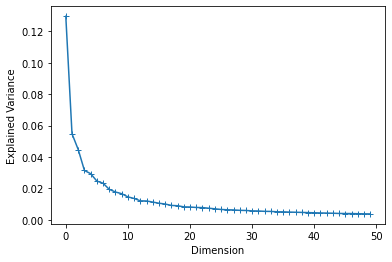

In [193]:
plt.plot(explained_variance_ratio[0:50],marker = '+')
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')

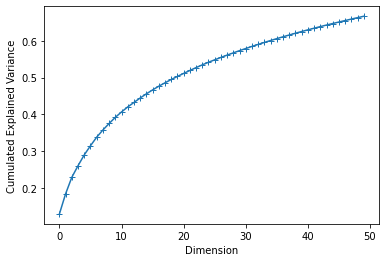

In [196]:
plt.plot(np.cumsum(explained_variance_ratio)[0:50],marker = '+')
plt.xlabel('Dimension')
plt.ylabel('Cumulated Explained Variance')
plt.show()

In [160]:
test_feature_dataloader = DataLoader(np.array(test_features), batch_size=64, shuffle=True)
test_feature_low = []

for data in test_feature_dataloader:

    output = model(data.float().to(device))
    model.encoder_output_layer.register_forward_hook(get_activation('test_feature'))
    test_feature_low.append(activation['test_feature'].cpu().numpy())
test_feature_low_stack = np.vstack(test_feature_low)

In [162]:
test_labels_low = []

for data in test_dataloader:

    output = model(data.float().to(device))
    model.encoder_output_layer.register_forward_hook(get_activation('test_label'))
    test_labels_low.append(activation['test_label'].cpu().numpy())
test_labels_low_stack = np.vstack(test_labels_low)

In [ ]:
transform_train_label = train_label_transform.transform(train_labels)
transform_train_


In [164]:
from sklearn.ensemble import RandomForestRegressor
rf_clf = RandomForestRegressor(n_estimators=200)
rf_clf.fit(training_feature_low_stack,training_labels_low_stack)

RandomForestRegressor(n_estimators=200)

In [166]:
rf_clf.score(test_feature_low_stack,test_labels_low_stack)

-0.020195111075343265

In [167]:
low_predict_label = rf_clf.predict(test_feature_low_stack)

In [ ]:
def distance(str1, str2):
    """Simple Levenshtein implementation for eval."""
    m = np.zeros([len(str2)+1, len(str1)+1])
    for x in range(1, len(str2) + 1):
        m[x][0] = m[x-1][0] + 1
    for y in range(1, len(str1) + 1):
        m[0][y] = m[0][y-1] + 1
    for x in range(1, len(str2) + 1):
        for y in range(1, len(str1) + 1):
            if str1[y-1] == str2[x-1]:
                dg = 0
            else:
                dg = 1
            m[x][y] = min(m[x-1][y] + 1, m[x][y-1] + 1, m[x-1][y-1] + dg)
    return int(m[len(str2)][len(str1)])

In [ ]:
distances_smart = []
distances_dumb = []
for i in range(500):
    distances_smart.append(distance(lr_clf.predict(test_features)[i],test_labels[i]))
    distances_dumb.append(distance(test_features[i],test_labels[i]))


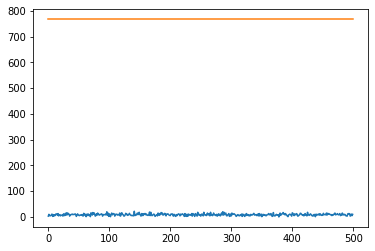

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances_smart)
plt.plot(distances_dumb)

In [ ]:
np.mean(np.array(distances_smart))

8.622

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])

regr.score(X_test, y_test)

Steps of our great method:
1. Get the language
2. Fine-tune BERT (or other) on word encoding closeness with levhenstein distance ( adding a noise to the encoded word and decode it, taking leveinstein(word,word'))
3. Use encoded form + Morphological Attributes -> MLP layer -> encoded Lemma estimator -> decode with Bert
4. Use the Levenstein distance between encoded lemma / encoded lemma estimator to fine-tune Noise at step 2.

Repeat until "convergence"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=62acceee-5efe-4784-8fac-a616ab59b2ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>